[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)

In [16]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [17]:
from functools import partial
import math
import timeit
import numpy as np, scipy
from scipy.optimize import elementwise
from matplotlib import pyplot
from collections import namedtuple

import os
os.environ['NUMBA_DISABLE_JIT']='1'
import numba

from open_atmos_jupyter_utils import show_plot
from PySDM import physics
from PySDM_examples.Grabowski_and_Pawlowska_2023.settings import DRY_SPECTRA
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.physics.dimensional_analysis import DimensionalAnalysis

# import warnings
# warnings.filterwarnings("error")

In [18]:
n_sd=2**3 # TEMP 2**10
commons = {
    'kappa': 1.28,
    'init_temperature_K': 300,
    'init_dry_pressure_Pa': 100000,
    'total_water_mixing_ratio': 21.5/1000,
    't_max_s': 300, # TEMP!
}

dry_spectra = {
    aerosol: ConstantMultiplicity(DRY_SPECTRA[aerosol][commons['kappa']]).sample_deterministic(n_sd)
    for aerosol in DRY_SPECTRA
}

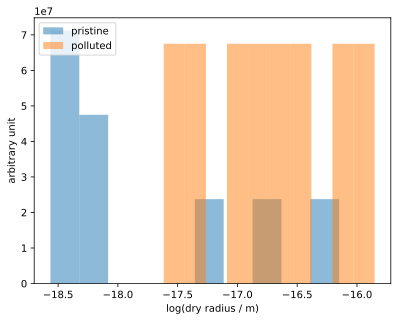

In [19]:
for aerosol, data in dry_spectra.items():
    pyplot.hist(np.log(data[0]), weights=data[1], density=False, label=aerosol, alpha=.5)
pyplot.gca().set(ylabel="arbitrary unit", xlabel="log(dry radius / m)")
pyplot.legend()
show_plot("spectrum")


In [20]:
make_namedtuple = lambda name, items: namedtuple(name, items.keys())(*items.values())

ix = make_namedtuple("I", {
    "x": slice(0, n_sd),
    "pd": n_sd,
    "T": n_sd + 1,
    "size": n_sd + 2
})

In [21]:
formulae = make_namedtuple("F", {
    # eq. (1) in the NPG paper
    "drw_dt": lambda c, rw, rho_v, rho_o: c.D_eff / c.rho_w * (rho_v - rho_o) / rw,
    # eq. (4) in the NPG paper
    "RH_eq": lambda c, rw, rd: 1 + c.A / rw - c.κ * (rd / rw)**3,
    # eq. (13) in the NPG paper
    "dpd_dt": lambda c, rhod, w: -rhod * c.g * w,
    "dT_dt": lambda c, dpd_dt, dqv_dt, rhod: (dpd_dt / rhod - dqv_dt * c.l_v) / c.cp_d,
    # Bolton 1980 saturation vapour pressure formula (https://doi.org/10.1175/1520-0493(1980)108%3C1046:TCOEPT%3E2.0.CO;2)
    "pvs": lambda c, T: c.B80_G0 * np.exp((c.B80_G1 * (T - c.T0)) / ((T - c.T0) + c.B80_G2)),
    # trivia
    "rhod": lambda c, pd, T: pd / c.R_d / T,
    "rhov": lambda c, pv, T: pv / c.R_v / T,
    

    "RH": lambda c, ml, rho_vs, rhod: rhod * (c.qt - ml / c.m_d) / rho_vs,
    "dqv_dt": lambda c, rw, drw_dt: -4 * np.pi * np.dot(c.xi * rw**2, drw_dt) / c.m_d * c.rho_w,
    "w": lambda c, t: c.w_mean * np.pi / 2 * np.sin(np.pi * t * c.w_mean / c.z_half),
    "z": lambda c, t: c.z_half / 2 * (1 - np.cos(np.pi * t * c.w_mean / c.z_half)),
    "r_c": lambda c, rd: (3 * c.κ * rd**3 / c.A)**.5,
    "ml": lambda c, rw: np.dot(rw**3, c.xi) * 4/3 * np.pi * c.rho_w,
    # size variable:    
    "rw": lambda c, x: c.r0 * np.exp(x),
    "x": lambda c, rw: np.log(rw / c.r0), 
    "drw_dx": lambda rw : rw,
    
    # "qv": lambda rhov, rhod: rhov/rhod,
    # "pd": lambda c, qv, rhod, T: rhod * (1 + qv) * (c.R_v / (1 / qv + 1) + c.R_d / (1 + qv)) * T,
    "thd": lambda c, T, pd: T * np.power(c.p1000 / pd, c.R_d / c.cp_d),
    "T": lambda c, θd, ρd: θd * (ρd * θd / c.p1000 * c.R_d)**(c.R_d/c.cp_d / (1 - c.R_d/c.cp_d)),
    "pd": lambda c, T, ρd: c.R_d * T * ρd, 
})

In [22]:
def ode_jacobian(c, rw, T, w):
    Jxx = np.diag(-2 / rw**2) - 4 * np.pi * D / rhod / md * np.multiply.outer(1 / rw**2, xi * rw**3)
    Jxp = D / rho_w / rw**2 / c.Rd / T * (qt - ml/md)
    JxT = 0 #
    Jpx = 0 #
    Jpp = - 1 / c.Rd / T * c.g * w
    JpT = 0 #
    JTx = 0 #
    JTp = 0 #
    JTT = 0 #

In [23]:
import mendeleev
def constants(**kwargs):
    
    r_dry = kwargs['dry_spectrum'][0]
    multiplicities = kwargs['dry_spectrum'][1]
    
    SI = physics.si
    M_a = (
        0.78 * 2 * mendeleev.N.atomic_weight * SI.g / SI.mole + 
        0.21 * 2 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        0.01 * 1 * mendeleev.Ar.atomic_weight * SI.g / SI.mole
    )
    M_v = (
        1 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        2 * mendeleev.H.atomic_weight * SI.g / SI.mole
    )
    R_str = scipy.constants.R * SI.J / SI.K / SI.mole
    
    constants = make_namedtuple("C", {
        "R_d": R_str / M_a,
        "R_v": R_str / M_v,
        "cp_d": 1000 * SI.J / SI.kg / SI.K,
        "l_v": 45000 * SI.joule / SI.mol / M_v,
        "g": scipy.constants.g * SI.m / SI.s**2,
        "A": 1e-3 * SI.um,
        "rho_w": 1 * SI.kg / SI.litre,
        "D_eff": 2.3e-5 * SI.metre**2 / SI.s,
        "T0": scipy.constants.zero_Celsius * SI.K,
        "p1000": 1000 * SI.hPa,

        "B80_G0": 6.112 * SI.hPa,
        "B80_G1": 17.67 * SI.dimensionless,
        "B80_G2": 243.5 * SI.K,
        
        "r0": SI.nm,
        "κ": kwargs['kappa'],
        "rd": r_dry * SI.m,
        "xi": multiplicities,
        "m_d": 1 * SI.kg,
        "qt": kwargs['total_water_mixing_ratio'],
        "t_max": kwargs['t_max_s'] * SI.s,
        "w_mean": kwargs['w_multiplier'] * SI.m / SI.s,
        "z_half": 150 * SI.m #TEMP
    })
    return constants, SI

def initial_condition(SI, r_dry, const, init_dry_pressure_Pa, init_temperature_K,):
    RH = formulae.RH(const,
                 ml=0,
                 rho_vs=formulae.rhov(const, pv=formulae.pvs(const, init_temperature_K), T=init_temperature_K),
                 rhod=formulae.rhod(const, pd=init_dry_pressure_Pa, T=init_temperature_K)
                )
    result = elementwise.find_root(lambda rw, rd: RH - formulae.RH_eq(const, rw, rd), (r_dry, formulae.r_c(const, const.rd)), args=(const.rd,))
    assert all(result.success)

    y0 = [0] * ix.size
    y0[ix.pd] = init_dry_pressure_Pa * SI.Pa
    y0[ix.T] = init_temperature_K * SI.K
    y0[ix.x] = formulae.x(const, rw=result.x)
    
    return y0

In [24]:
jit_compile = numba.jit(error_model='numpy', fastmath=True)
jf = make_namedtuple("J", {k: jit_compile(v) for k, v in formulae._asdict().items()})

@jit_compile
def ode_rhs(t, y, c):
    rhod = jf.rhod(c, pd=y[ix.pd], T=y[ix.T])
    rho_vs = jf.rhov(c, pv=jf.pvs(c, y[ix.T]), T=y[ix.T])
    rw = jf.rw(c, x=y[ix.x])
    ml = jf.ml(c, rw=rw)
    RH = jf.RH(c, ml=ml, rho_vs=rho_vs, rhod=rhod)
    RH_eq = jf.RH_eq(c, rw=rw, rd=c.rd)
    
    dy_dt = np.empty_like(y)
    dy_dt[ix.pd] = jf.dpd_dt(c, rhod=rhod, w=jf.w(c, t))
    dy_dt[ix.x] = jf.drw_dt(c, rw=rw, rho_v=RH * rho_vs, rho_o=RH_eq * rho_vs) / jf.drw_dx(rw)
    dy_dt[ix.T] = jf.dT_dt(c, dpd_dt=dy_dt[ix.pd], dqv_dt=jf.dqv_dt(c, rw=rw, drw_dt=dy_dt[ix.x] * jf.drw_dx(rw)), rhod=rhod)
    return dy_dt

In [25]:
@jit_compile
def solve(y, nt, dt, fun, args):
    for step in range(1, nt + 1):
        y[:, step] = y[:, step - 1] + dt * fun(step * dt, y[:, step - 1], *args)
    return y

def explicit_euler(*, fun, t_span, y0, min_step, max_step, args):
    dt = min_step
    nt = int((t_span[1] - t_span[0]) / dt)
    y = np.empty(shape=(len(y0), nt + 1))
    y[:, 0] = y0
    return make_namedtuple(
        "Solution", {
        'success': True,
        'message': '',
        'y': solve(y, nt, dt, fun, args),
        't': np.linspace(t_span[0], t_span[1], nt+1, endpoint=True)
        })

In [26]:
# Bartman et al. adaptivity algorithm:
# - does not require additional state-vector-size memory
# - implicit-in-size/explicit-in-thermodynamicx

@jit_compile
def adapt_substeps(step_impl_args, n_substeps, rh, rtol_rh):
    """ calls `calculate_ml_new(fake=True) ... """
    return 1, True

@jit_compile
def calculate_ml_new(c, x, dt, fake, rh_new):
    """ implicit Euler solution for drop sizes altering the 
    `x` argument if `fake` if False, otherwise returning the
    new liquid water mass without changing `x` """
    for drop in numba.prange(len(x)):
        pass
    rw = jf.rw(c, x=x)
    return jf.ml(c, rw=rw), True

@jit_compile
def step(c, x, qv, dqv_dt, θd, dθd_dt, ρd, dρd_dt, dt, n_substeps, fake):
    """ explicit (trapezoidal) integration of thermodynamics coupled
    with external implicit solver for drop sizes """
    dt /= n_substeps
    # rw_old = jf.rw(c, x=x)
    # ml_old = jf.ml(c, rw=rw_old)
    success = True
    for _ in range(n_substeps):
        θd += dt * dθd_dt / 2
        qv += dt * dqv_dt / 2
        ρd += dt * dρd_dt / 2
        rh_new = 0 # TODO
        ml_new, success_within_substep = calculate_ml_new(c, x, dt, fake, rh_new)
        # dml_dt = (ml_new - ml_old) / dt
        # dqv_dt_cond = -dml_dt / c.m_d
        # dθd_dt_cond = 0 #formulae.dθd_dt()
        θd += dt * (dθd_dt / 2 + 0) #dθd_dt_cond)
        qv += dt * (dqv_dt / 2 + 0) #dqv_dt_cond)
        ρd += dt * dρd_dt / 2
        # ml_old = ml_new
        success = success and success_within_substep
    return qv, θd, success

@jit_compile
def qθρ(c, pd, T, rw):
    ρd = jf.rhod(c, pd=pd, T=T)
    pvs = jf.pvs(c, T)
    RH = jf.RH(
        c,
        ml=jf.ml(c, rw=rw),
        rho_vs=jf.rhov(c, pv=pvs, T=T),
        rhod=ρd
    )
    return (
        jf.rhov(c, pv=RH * pvs, T=T) / ρd,
        jf.thd(c, T=T, pd=pd),
        ρd
    )

@jit_compile
def stepper(y, times, c, adaptive):
    success = True
    n_substeps = 1

    for i in range(1, len(times)):
        pd_old = y[ix.pd, i-1]
        T_old = y[ix.T, i-1]
        rw_old = jf.rw(c, x=y[ix.x, i-1])
        qv_old, θd_old, ρd_old = qθρ(c, pd_old, T_old, rw_old)
        
        dpd_dt_old = jf.dpd_dt(c, rhod=ρd_old, w=jf.w(c, times[i-1]))
        dT_dt_old = jf.dT_dt(c, dpd_dt=dpd_dt_old, dqv_dt=0, rhod=ρd_old)

        dt = times[i] - times[i-1]
        pd_new =  pd_old + dt * dpd_dt_old
        T_new = T_old + dt * dT_dt_old
        
        qv_new, θd_new, ρd_new = qθρ(c, pd_new, T_new, rw_old)

        y[ix.x, i] = y[ix.x, i-1]
        step_args = (
            c, y[ix.x, i],
            qv_old, (qv_new - qv_old) / dt,
            θd_old, (θd_new - θd_old) / dt,
            ρd_old, (ρd_new - ρd_old) / dt,
        )
        if adaptive:
            n_substeps, success = adapt_substeps(step_args, n_substeps, np.nan, np.nan)
        if success:
            qv_new, θd_new, success = step(*step_args, dt, n_substeps, False)
        else:
            qv_new, θd_new, = np.nan, np.nan

        y[ix.T, i] = jf.T(c, θd=θd_new, ρd=ρd_new)
        y[ix.pd, i] = jf.pd(c, T=y[ix.T, i], ρd=ρd_new)
        
    return success

def adaptive_solver(*, t_span, y0, min_step, max_step, args, adaptive):
    assert t_span[0] == 0  
    n_substeps_max = math.floor(t_span[1] / min_step)
    n_substeps_min = math.ceil(t_span[1] / max_step)
    
    y = np.empty(shape=(len(y0), n_substeps_min + 1))
    y[:, 0] = y0
    times = np.linspace(*t_span, y.shape[1], endpoint=True)
    success = stepper(y, times, args[0], adaptive)
    return make_namedtuple("AS", {
        'success': success,
        'message': __name__,
        'y': y,
        't': times
    })

In [27]:
def run(dry_spectra, w_multiplier, eps):
    solutions = {}
    times = {}
    for aerosol, dry_spectrum in dry_spectra.items():
        c, SI = constants(dry_spectrum=dry_spectrum, w_multiplier=w_multiplier, **commons)
        y0 = initial_condition(SI, dry_spectrum[0], const=c, init_dry_pressure_Pa=commons['init_dry_pressure_Pa'], init_temperature_K=commons['init_temperature_K'])
        for key, solver in {
            f"{aerosol}" : partial(adaptive_solver, adaptive=False),
            f"{aerosol}-LSODA" : partial(scipy.integrate.solve_ivp, method='LSODA', atol=0, rtol=eps, fun=ode_rhs),
        }.items():
            solution = [None]
            def do(solution):
                solution[0] = solver(
                    min_step=.005 / w_multiplier * SI.s,
                    t_span=(0, c.t_max / w_multiplier),
                    y0=y0,
                    max_step=.5 / w_multiplier * SI.s,
                    args=(c,),
                )
                assert solution[0].success, solution[0].message
            timer = timeit.Timer(partial(do, solution=solution))
            timer.timeit(number=1) # warmup (JIT, caches, ...)
            times[key] = timer.timeit(number=1)
            solutions[key]=solution[0]
    return solutions, times

In [28]:
velocities_multiplier = (1, 0.5, 0.002)
all_solutions = {}
all_times = {}
for w_idx, w_val in enumerate(velocities_multiplier):
    solutions_w, times_w = run(dry_spectra, w_multiplier=w_val, eps=1e-3)
    for key, solution in solutions_w.items():
        all_solutions[(w_idx, key)] = solution
        all_times[(w_idx, key)] = times_w[key]

/var/folders/gl/1t3c1h9x3ws6d68b11gr2rth0000gn/T/ipykernel_43330/927799699.py:23: RuntimeWarning: overflow encountered in exp
  "rw": lambda c, x: c.r0 * np.exp(x),
/var/folders/gl/1t3c1h9x3ws6d68b11gr2rth0000gn/T/ipykernel_43330/927799699.py:21: RuntimeWarning: overflow encountered in power
  "ml": lambda c, rw: np.dot(rw**3, c.xi) * 4/3 * np.pi * c.rho_w,
/var/folders/gl/1t3c1h9x3ws6d68b11gr2rth0000gn/T/ipykernel_43330/927799699.py:3: RuntimeWarning: invalid value encountered in divide
  "drw_dt": lambda c, rw, rho_v, rho_o: c.D_eff / c.rho_w * (rho_v - rho_o) / rw,
/var/folders/gl/1t3c1h9x3ws6d68b11gr2rth0000gn/T/ipykernel_43330/927799699.py:17: RuntimeWarning: overflow encountered in square
  "dqv_dt": lambda c, rw, drw_dt: -4 * np.pi * np.dot(c.xi * rw**2, drw_dt) / c.m_d * c.rho_w,


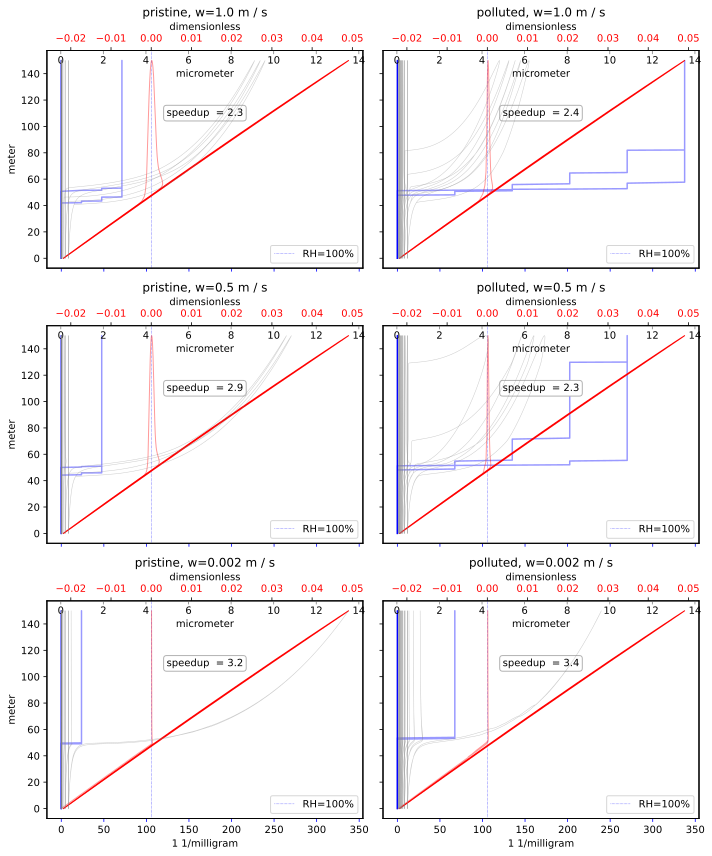

In [29]:
rows = []
for w_idx, w_val in enumerate(velocities_multiplier):
    row_keys = [f"w{w_idx}-{aerosol}" for aerosol in dry_spectra.keys()]
    rows.append(row_keys)

fig, axs = pyplot.subplot_mosaic(
    rows,
    sharey=True,
    sharex=True,
    figsize=(10, 4*len(velocities_multiplier)),
    tight_layout=True,
)
pyplot.subplots_adjust(hspace=0.1)
twin_prev = None
for w_idx, w_multiplier in enumerate(velocities_multiplier):
    for aerosol in dry_spectra.keys(): 
        key = f"w{w_idx}-{aerosol}"
        solution_keys = [k for k in all_solutions.keys() if k[0] == w_idx and k[1].startswith(aerosol)]
        
        twin_s = axs[key].twiny()
        twin_r = axs[key].twiny()
        if twin_prev:
            twin_s.sharex(twin_prev[0])
            twin_r.sharex(twin_prev[1])
        twin_prev = twin_s, twin_r
        
        with DimensionalAnalysis():
            c, SI = constants(
                dry_spectrum=dry_spectra[aerosol],
                kappa=commons['kappa'],
                total_water_mixing_ratio=commons['total_water_mixing_ratio'],
                t_max_s=commons['t_max_s'],
                w_multiplier=w_multiplier,
            )
            SI.setup_matplotlib()
            
            twin_s.axvline(0, linestyle=':', color='blue', linewidth=0.5, label="RH=100%")
            twin_s.tick_params(axis='x', labelcolor='red')
            twin_s.legend(loc='lower right')
    
            twin_r.xaxis.set_units(SI.um) 
            twin_r.tick_params(axis='x', direction='in', color='gray', pad=-15)
            twin_r.xaxis.set_label_coords(0.5, 0.88)
            
            axs[key].set_title(f"{aerosol}, w={c.w_mean:~}")    
            axs[key].xaxis.set_units(1/SI.mg)
            axs[key].tick_params(axis='x', color='blue')
            
            
            for sol_key in solution_keys:
                if "LSODA" in sol_key[1]:
                    alpha = .4
                else:
                    alpha = 1
                solution = all_solutions[sol_key]
                
                t = solution.t * SI.s
                pd = solution.y[ix.pd]* SI.Pa
                T = solution.y[ix.T]* SI.K
                rw = formulae.rw(c, solution.y[ix.x])
                ml = formulae.ml(c, rw=rw.T)

                RH = formulae.RH(
                    c,
                    ml=ml,
                    rho_vs=formulae.rhov(c, pv=formulae.pvs(c, T), T=T),
                    rhod=formulae.rhod(c, pd=pd, T=T)
                )
                twin_s.plot(RH - 1, formulae.z(c, t), color='red', linewidth=1, label="supersaturation", alpha=alpha)
                   
                for i in range(ix.x.start, ix.x.stop):
                    twin_r.plot(rw[i], formulae.z(c, t), color='gray', linewidth=.5, alpha=alpha)

                axs[key].plot(np.sum(np.where(rw.T > formulae.r_c(c, c.rd), c.xi, 0), axis=1) / c.m_d, formulae.z(c, t), color='blue', linewidth=1.5, alpha=alpha)
                
            speedup = all_times[solution_keys[1]] / all_times[solution_keys[0]]
            axs[key].annotate(
                f"speedup  = {speedup:.2g}",
                xy=(0.5, 0.7),
                xycoords="axes fraction",
                ha="center",
                bbox=dict(
                    boxstyle="round,pad=0.3",
                    fc="white",
                    ec="0.7",
                    lw=1,
                )
            )
show_plot("scipy_solver")
                        

TODO:
- 
- adaptive ODE solver
- plots for different tolerances
- time vs. number of droplets scaling plot
- color-scale dt_adapt
- tolerances in SciPy solver
- comparison for different size attributes (time efficiency, accuracy)
- Numba threading
- thermo triplet arrays!

IDEAS:
- Jacobian
- isotopes